In [1]:
import maze_library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


2025-04-05 12:29:17.332961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 12:29:17.339996: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 12:29:17.350555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743852557.367015 1010620 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743852557.371647 1010620 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743852557.385430 1010620 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
def map_int_to_direction(input):
    if input == 0:
        return maze_library.Direction.North
    if input == 1:
        return maze_library.Direction.East
    if input == 2:
        return maze_library.Direction.South
    else:
        return maze_library.Direction.West

In [3]:
env = maze_library.init_environment_python(10,10)
maze_library.create_kruzkals_maze(env)
maze_library.make_maze_imperfect(env)

In [4]:
def action_result_to_tuple(action_result):
    """
    Converts an ActionResult object into a tuple.

    Args:
        action_result (ActionResult): The result of an action in the environment.

    Returns:
        tuple: (observation, reward, done, truncated, info)
    """
    observation = action_result.observation  # The new observation after taking action
    reward = action_result.reward  # Reward received
    done = action_result.is_done  # Whether the episode is finished
    truncated = action_result.is_truncated  # Whether the episode was truncated
    info = action_result.info # Additional info

    return observation, reward, done, truncated, info


In [5]:
def action_result_to_input_vector(state, info):
    available_paths = state.available_paths
    visited_paths = state.visited_paths
    return np.array([
        available_paths.get(maze_library.Direction.North, 0)/10,
        visited_paths.get(maze_library.Direction.North, False),
        available_paths.get(maze_library.Direction.East, 0)/10,
        visited_paths.get(maze_library.Direction.East, False),
        available_paths.get(maze_library.Direction.South, 0)/10,
        visited_paths.get(maze_library.Direction.South, False),
        available_paths.get(maze_library.Direction.West, 0)/10,
        visited_paths.get(maze_library.Direction.West, False),
        state.current_location[0] / 10,
        state.current_location[1] / 10,
        state.end_node[0] / 10,
        state.end_node[1] / 10,
        info.previous_node[0] / 10,
        info.previous_node[1] / 10,
        info.manhattan_distance / 10,
        info.goal_dx/5,
        info.goal_dy/5,
        info.visited_amount 

    ])

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [18]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])



/Development/FYP/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-05 12:29:19.152949: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
print("Initial Q-values:", model.predict(np.random.rand(1, 18)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Initial Q-values: [[ 0.66876256 -0.5210265   0.02468402 -0.40264976]]


In [8]:
def epsilon_greedy_policy(flat_state, epsilon):
    if np.random.rand() < epsilon:
        # Choose only from valid actions
        return np.random.choice(n_outputs)
    else:
        Q_values = model.predict(flat_state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()


In [9]:
from collections import deque

replay_buffer = deque(maxlen=8000)

In [10]:
def sample_experiences(batch_size):
    sorted_experiences = sorted(replay_buffer, key=lambda exp: abs(exp[2]), reverse=True)
    half_batch = batch_size // 2

    # Ensure there are enough samples to choose from
    num_experiences = len(sorted_experiences)
    if num_experiences < batch_size:
        batch = sorted_experiences
    else:
        high_priority_samples = sorted_experiences[:half_batch]
        random_samples = [sorted_experiences[i] for i in np.random.choice(num_experiences, half_batch, replace=False)]
        batch = high_priority_samples + random_samples
    
    return [
        np.array([experience[field_index] for experience in batch], dtype=np.float32)
        for field_index in range(6)
    ]



In [11]:
reward_log = []
def play_one_step(env, state, info, epsilon):
    flat_state = action_result_to_input_vector(state, info)
    action = epsilon_greedy_policy(flat_state, epsilon)
    action_obj = maze_library.create_action(map_int_to_direction(action))
    next_state, reward, done, truncated, new_info = action_result_to_tuple(env.take_action(action_obj))
    flat_next_state = action_result_to_input_vector(next_state, new_info)
    reward_log.append(reward)
    replay_buffer.append((flat_state, action, reward, flat_next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [12]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
highest_reward = -1000000

In [13]:
batch_size = 64
discount_factor = 0.96
q_value_log = []
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
loss_fn = tf.keras.losses.Huber(delta=1.0) # Use the class
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        q_value_log.extend(Q_values.numpy().flatten())
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [14]:
# Visualization function
def plot_q_values():
    plt.figure(figsize=(10, 5))
    plt.plot(q_value_log)
    plt.title("Q-Values Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Q-Value")
    plt.grid(True)
    plt.show()


Episode: 0, Steps: 5, eps: 1.000, reward = -19.15


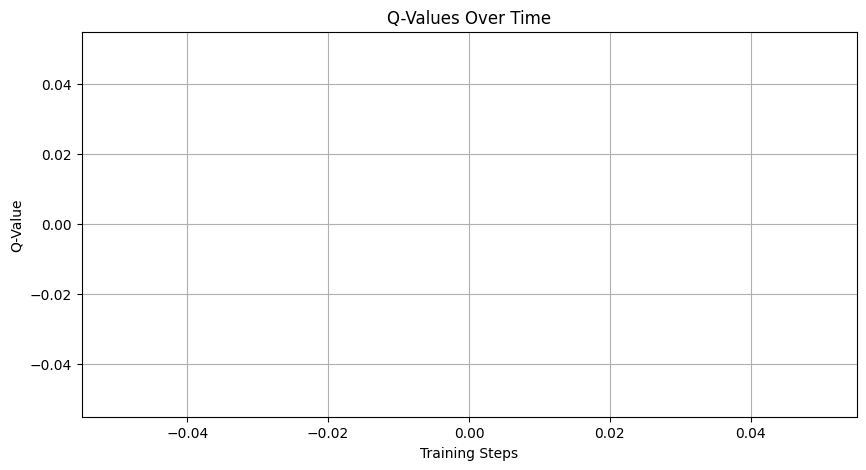

Episode: 1, Steps: 7, eps: 1.000, reward = -16.4
Episode: 2, Steps: 5, eps: 0.999, reward = -19.15
Episode: 3, Steps: 20, eps: 0.999, reward = -24.1
Episode: 4, Steps: 5, eps: 0.999, reward = -19.15
Episode: 5, Steps: 19, eps: 0.998, reward = -23.35
Episode: 6, Steps: 5, eps: 0.998, reward = -19.15
Episode: 7, Steps: 39, eps: 0.997, reward = -24.55
Episode: 8, Steps: 10, eps: 0.997, reward = -19.15
Episode: 9, Steps: 5, eps: 0.997, reward = -19.15
Episode: 10, Steps: 5, eps: 0.996, reward = -19.15
Episode: 11, Steps: 23, eps: 0.996, reward = -25.0
Episode: 12, Steps: 19, eps: 0.996, reward = -21.95
Episode: 13, Steps: 7, eps: 0.995, reward = -15.0
Episode: 14, Steps: 23, eps: 0.995, reward = -15.35
Episode: 15, Steps: 27, eps: 0.994, reward = -24.000000000000004
Episode: 16, Steps: 36, eps: 0.994, reward = -35.3
Episode: 17, Steps: 5, eps: 0.994, reward = -19.15
Episode: 18, Steps: 27, eps: 0.993, reward = -18.2
Episode: 19, Steps: 5, eps: 0.993, reward = -19.15
Episode: 20, Steps: 5, 

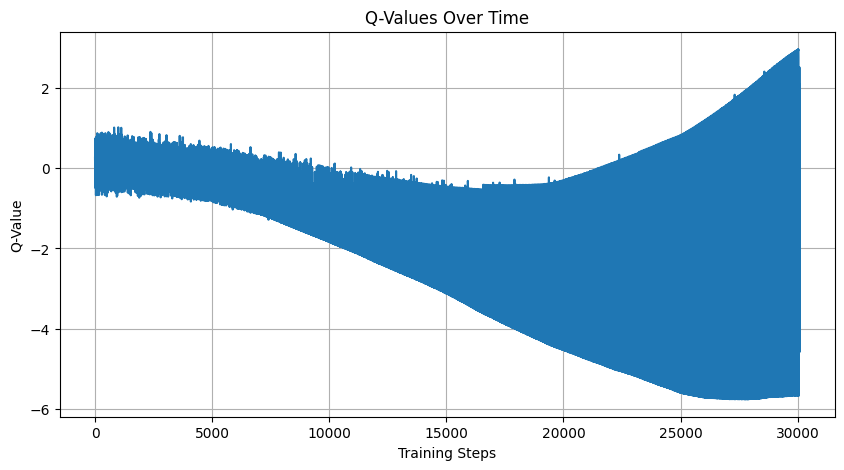

Episode: 501, Steps: 12, eps: 0.814, reward = -19.8
Episode: 502, Steps: 27, eps: 0.814, reward = -30.499999999999996
Episode: 503, Steps: 29, eps: 0.814, reward = -30.3
Episode: 504, Steps: 13, eps: 0.813, reward = -14.2
Episode: 505, Steps: 18, eps: 0.813, reward = -13.200000000000001
Episode: 506, Steps: 39, eps: 0.813, reward = -18.400000000000002
Episode: 507, Steps: 5, eps: 0.812, reward = -19.15
Episode: 508, Steps: 9, eps: 0.812, reward = -17.2
Episode: 509, Steps: 7, eps: 0.811, reward = -16.8
Episode: 510, Steps: 22, eps: 0.811, reward = -16.2
Episode: 511, Steps: 32, eps: 0.811, reward = -23.749999999999996
Episode: 512, Steps: 10, eps: 0.810, reward = -15.55
Episode: 513, Steps: 19, eps: 0.810, reward = -17.85
Episode: 514, Steps: 15, eps: 0.810, reward = -18.8
Episode: 515, Steps: 7, eps: 0.809, reward = -16.8
Episode: 516, Steps: 11, eps: 0.809, reward = -16.65
Episode: 517, Steps: 55, eps: 0.809, reward = -26.35
Episode: 518, Steps: 6, eps: 0.808, reward = -17.15
Episode

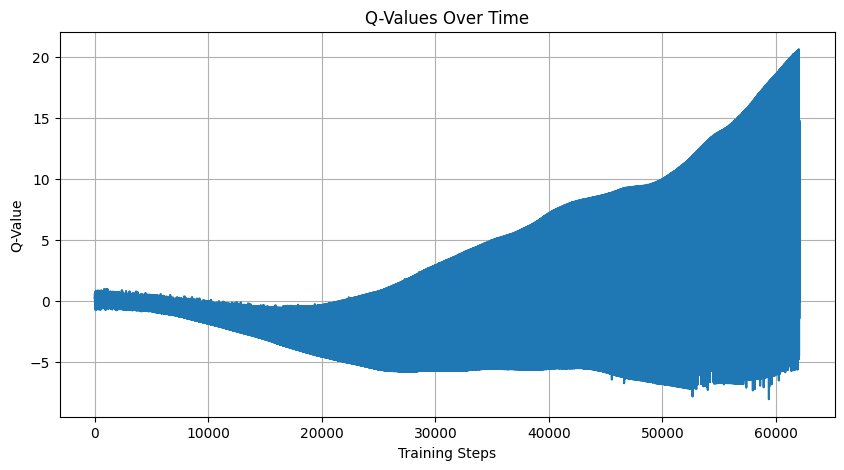

Episode: 1001, Steps: 21, eps: 0.629, reward = -24.95
Episode: 1002, Steps: 8, eps: 0.629, reward = -14.7
Episode: 1003, Steps: 11, eps: 0.629, reward = -16.55
Episode: 1004, Steps: 39, eps: 0.628, reward = -16.0
Episode: 1005, Steps: 10, eps: 0.628, reward = -16.9
Episode: 1006, Steps: 14, eps: 0.627, reward = -22.85
Episode: 1007, Steps: 14, eps: 0.627, reward = -22.15
Episode: 1008, Steps: 13, eps: 0.627, reward = -21.4
Episode: 1009, Steps: 21, eps: 0.626, reward = -24.599999999999998
Episode: 1010, Steps: 51, eps: 0.626, reward = -24.85
Episode: 1011, Steps: 27, eps: 0.626, reward = -24.25
Episode: 1012, Steps: 38, eps: 0.625, reward = -21.95
Episode: 1013, Steps: 35, eps: 0.625, reward = -22.95
Episode: 1014, Steps: 22, eps: 0.624, reward = -18.95
Episode: 1015, Steps: 29, eps: 0.624, reward = -17.1
Episode: 1016, Steps: 21, eps: 0.624, reward = -19.5
Episode: 1017, Steps: 25, eps: 0.623, reward = -26.2
Episode: 1018, Steps: 20, eps: 0.623, reward = 44.6
Episode: 1019, Steps: 8, 

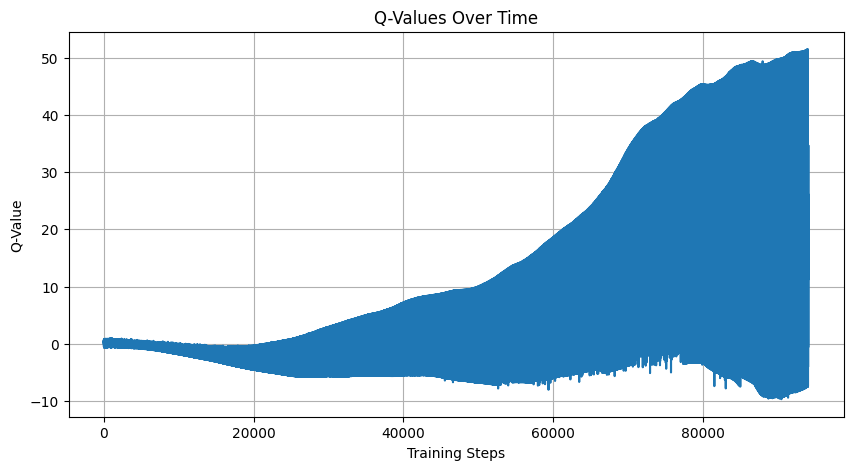

Episode: 1501, Steps: 19, eps: 0.444, reward = -12.399999999999999
Episode: 1502, Steps: 44, eps: 0.444, reward = -24.45
Episode: 1503, Steps: 5, eps: 0.443, reward = -19.15
Episode: 1504, Steps: 10, eps: 0.443, reward = -19.150000000000002
Episode: 1505, Steps: 21, eps: 0.443, reward = -23.0
Episode: 1506, Steps: 13, eps: 0.442, reward = -23.200000000000003
Episode: 1507, Steps: 5, eps: 0.442, reward = -19.15
Episode: 1508, Steps: 23, eps: 0.441, reward = -21.65
Episode: 1509, Steps: 5, eps: 0.441, reward = -19.15
Episode: 1510, Steps: 24, eps: 0.441, reward = -17.5
Episode: 1511, Steps: 5, eps: 0.440, reward = -19.15
Episode: 1512, Steps: 5, eps: 0.440, reward = -19.15
Episode: 1513, Steps: 5, eps: 0.440, reward = -19.15
Episode: 1514, Steps: 13, eps: 0.439, reward = -22.200000000000003
Episode: 1515, Steps: 5, eps: 0.439, reward = -19.15
Episode: 1516, Steps: 8, eps: 0.439, reward = -16.200000000000003
Episode: 1517, Steps: 5, eps: 0.438, reward = -19.15
Episode: 1518, Steps: 5, eps

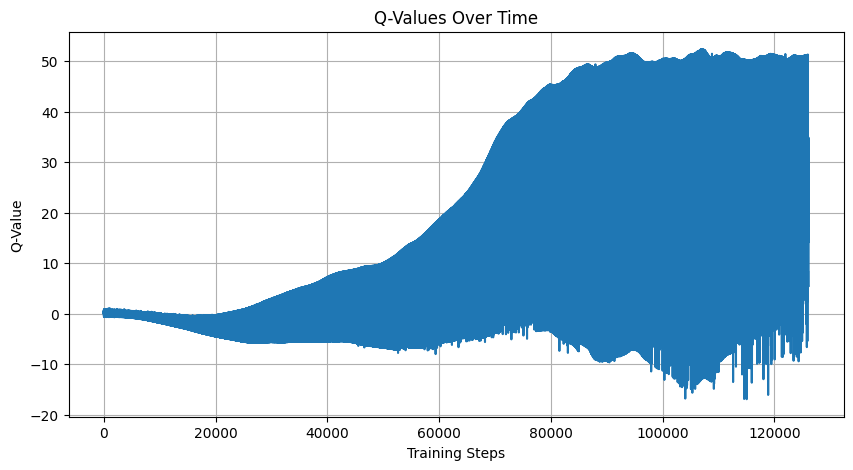

Episode: 2001, Steps: 5, eps: 0.259, reward = -19.15
Episode: 2002, Steps: 5, eps: 0.259, reward = -19.15
Episode: 2003, Steps: 5, eps: 0.258, reward = -19.15
Episode: 2004, Steps: 5, eps: 0.258, reward = -19.15
Episode: 2005, Steps: 5, eps: 0.257, reward = -19.15
Episode: 2006, Steps: 5, eps: 0.257, reward = -19.15
Episode: 2007, Steps: 5, eps: 0.257, reward = -19.15
Episode: 2008, Steps: 22, eps: 0.256, reward = 59.05
Episode: 2009, Steps: 5, eps: 0.256, reward = -19.15
Episode: 2010, Steps: 9, eps: 0.256, reward = -22.85
Episode: 2011, Steps: 12, eps: 0.255, reward = -16.25
Episode: 2012, Steps: 5, eps: 0.255, reward = -19.15
Episode: 2013, Steps: 10, eps: 0.254, reward = -14.1
Episode: 2014, Steps: 11, eps: 0.254, reward = -13.149999999999999
Episode: 2015, Steps: 11, eps: 0.254, reward = 56.95
Episode: 2016, Steps: 14, eps: 0.253, reward = -16.5
Episode: 2017, Steps: 20, eps: 0.253, reward = -17.5
Episode: 2018, Steps: 10, eps: 0.253, reward = -14.1
Episode: 2019, Steps: 19, eps: 

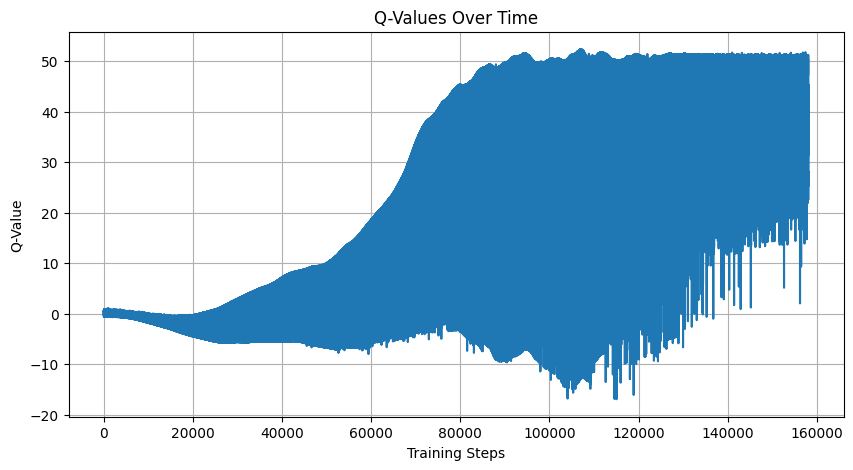

Episode: 2501, Steps: 20, eps: 0.074, reward = -10.799999999999999
Episode: 2502, Steps: 8, eps: 0.073, reward = -16.1
Episode: 2503, Steps: 8, eps: 0.073, reward = -16.1
Episode: 2504, Steps: 8, eps: 0.073, reward = -16.1
Episode: 2505, Steps: 8, eps: 0.072, reward = -16.1
Episode: 2506, Steps: 8, eps: 0.072, reward = -16.1
Episode: 2507, Steps: 8, eps: 0.071, reward = -16.1
Episode: 2508, Steps: 8, eps: 0.071, reward = -16.1
Episode: 2509, Steps: 19, eps: 0.071, reward = -11.1
Episode: 2510, Steps: 8, eps: 0.070, reward = -16.1
Episode: 2511, Steps: 10, eps: 0.070, reward = -14.1
Episode: 2512, Steps: 8, eps: 0.070, reward = -16.1
Episode: 2513, Steps: 8, eps: 0.069, reward = -16.1
Episode: 2514, Steps: 8, eps: 0.069, reward = -16.1
Episode: 2515, Steps: 8, eps: 0.069, reward = -16.1
Episode: 2516, Steps: 8, eps: 0.068, reward = -16.1
Episode: 2517, Steps: 8, eps: 0.068, reward = -16.1
Episode: 2518, Steps: 8, eps: 0.067, reward = -16.1
Episode: 2519, Steps: 8, eps: 0.067, reward = -

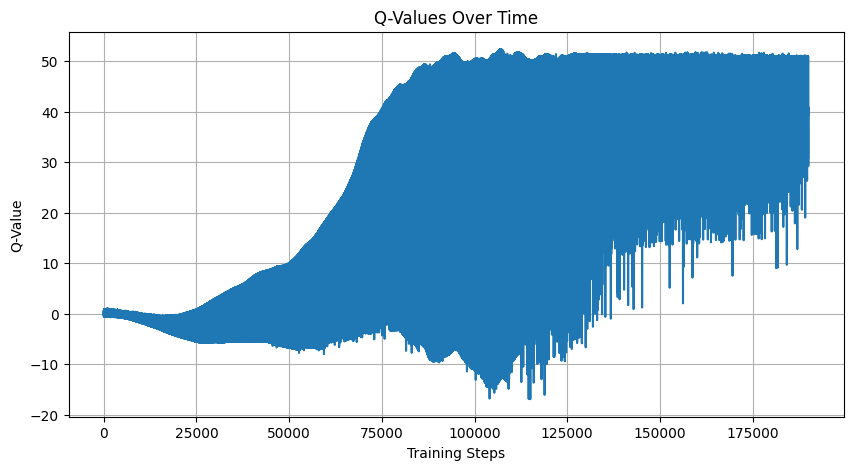

In [ ]:
steps = 3000

# In the plotting function:
for episode in range(steps):
    result = env.reset()   
    obs, reward, done, truncated, info = action_result_to_tuple(result)
    cumilative_reward = 0
    for step in range(steps):
        epsilon = max(1 - episode / (steps * 0.9), 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, info, epsilon)
        cumilative_reward += reward
        if done or truncated:
            break

    # Extra debug information
    print(f"\rEpisode: {episode}, Steps: {step}, eps: {epsilon:.3f}, reward = {cumilative_reward}")
    rewards.append(cumilative_reward)
    
    if cumilative_reward > highest_reward:
        best_weights = model.get_weights()
        highest_reward = cumilative_reward

    if episode > 30:
        training_step(batch_size)
    if episode % 500 == 499:
        plot_q_values()
        
    with open(f'../mazeLogs/solve{episode}.json', 'w') as file:
        file.write(env.to_json_python())

    
plot_q_values()

model.set_weights(best_weights)  # extra code – restores the best model weights

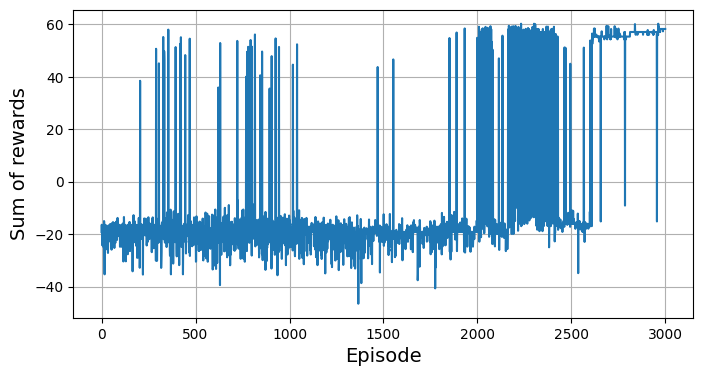

In [16]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

TypeError: `bins` must be an integer, a string, or an array

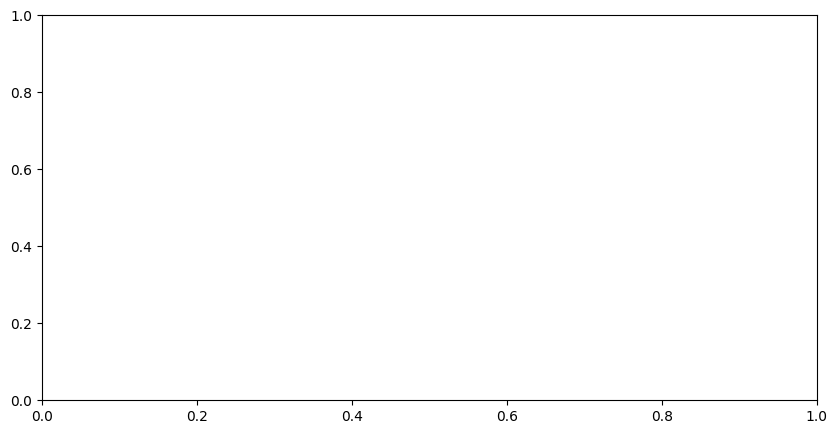

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(reward_log, bins=0.1, edgecolor='black')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()